In [4]:
import numpy as np
import matplotlib.pyplot as plt

/var/folders/25/vg8ydb454_z3v37m53jqj5280000gn/T/ipykernel_48276/2460474113.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  X[n] = (1.0 / T0) * np.trapz(integrand, tau)


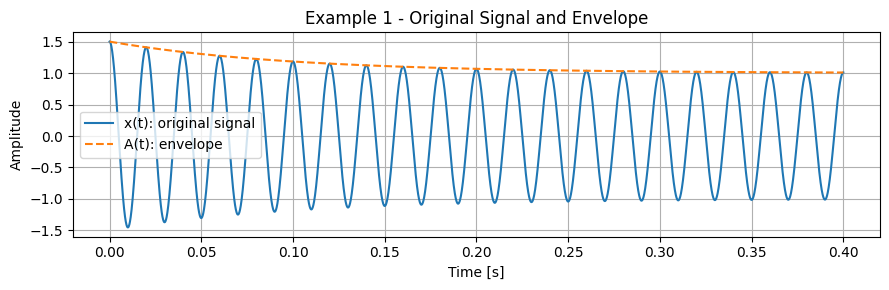

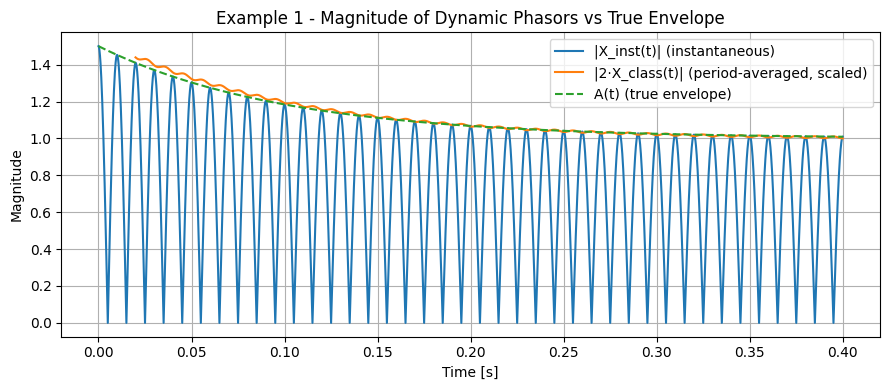

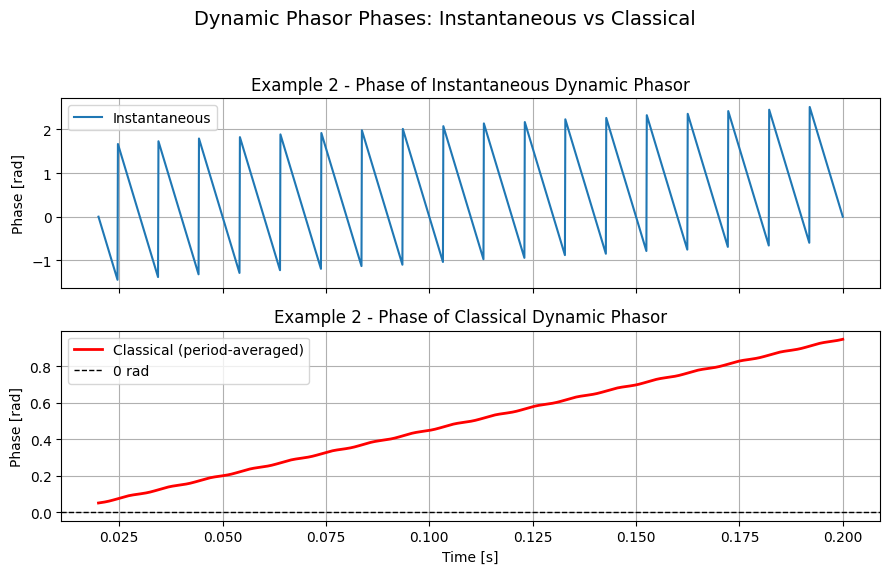

In [5]:
# =====================================================
# Dynamic Phasor Simulation
# - Example 1: Amplitude-varying signal (magnitude)
# - Example 2: Phase-varying signal (phase)
# This script is used to generate the figures in the report.
# =====================================================

# -------------------------
# Common parameters
# -------------------------
f0 = 50.0                    # [Hz] fundamental frequency
omega0 = 2 * np.pi * f0      # [rad/s] fundamental angular frequency
T0 = 1.0 / f0                # [s] fundamental period

fs = 10_000.0                # [Hz] sampling frequency
dt = 1.0 / fs                # [s] sampling interval
t_end = 0.4                  # [s] total simulation time
t = np.arange(0.0, t_end + dt, dt)


def classical_dynamic_phasor(x, t, omega0, T0):
    """
    Compute the classical (period-averaged) dynamic phasor for k = 1.

    X_class(t) = (1/T0) ∫_{t-T0}^{t} x(τ) e^{-j ω0 τ} dτ

    The integral is evaluated numerically over a sliding window
    of length T0 using the trapezoidal rule.
    """
    dt = t[1] - t[0]
    Nwin = int(round(T0 / dt))         # number of samples per period
    N = len(t)
    X = np.full_like(t, np.nan, dtype=complex)

    for n in range(Nwin - 1, N):
        tau = t[n - Nwin + 1 : n + 1]          # time values in the window
        xw  = x[n - Nwin + 1 : n + 1]          # signal values in the window
        integrand = xw * np.exp(-1j * omega0 * tau)
        X[n] = (1.0 / T0) * np.trapz(integrand, tau)

    return X


# =====================================================
# Example 1: Amplitude-varying signal (magnitude)
# =====================================================

# Envelope: A(t) = 1 + 0.5 * exp(-t / tau_env)
tau_env = 0.1
A_t = 1.0 + 0.5 * np.exp(-t / tau_env)
x_amp = A_t * np.cos(omega0 * t)      # scalar test signal x(t)

# Instantaneous dynamic phasor (simple baseband representation)
X_inst_amp = x_amp * np.exp(-1j * omega0 * t)

# Classical dynamic phasor (k = 1)
X_class_amp = classical_dynamic_phasor(x_amp, t, omega0, T0)

# Theoretical relation: |X_class| ≈ A(t)/2 for a pure cosine.
# For comparison with the envelope, the magnitude is scaled by 2.
X_class_amp_scaled = 2.0 * X_class_amp

# ---- Figure 1: original signal and envelope ----
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3))
ax1.plot(t, x_amp, label="x(t): original signal")
ax1.plot(t, A_t, "--", label="A(t): envelope")
ax1.set_title("Example 1 - Original Signal and Envelope")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
ax1.grid(True)
ax1.legend()
fig1.tight_layout()

# ---- Figure 2: magnitude of phasors vs envelope ----
fig2, ax2 = plt.subplots(1, 1, figsize=(9, 4))
ax2.plot(t, np.abs(X_inst_amp), label="|X_inst(t)| (instantaneous)")
ax2.plot(t, np.abs(X_class_amp_scaled),
         label="|2·X_class(t)| (period-averaged, scaled)")
ax2.plot(t, A_t, "--", label="A(t) (true envelope)")
ax2.set_title("Example 1 - Magnitude of Dynamic Phasors vs True Envelope")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Magnitude")
ax2.grid(True)
ax2.legend()
fig2.tight_layout()


# =====================================================
# Example 2: Phase-varying signal (phase)
# =====================================================

# Here the amplitude is constant and the phase varies slowly:
# x_phi(t) = cos(omega0 * t + phi(t)),  phi(t) = 5 t
phi_t = 5.0 * t
x_phase = np.cos(omega0 * t + phi_t)

# Instantaneous dynamic phasor
X_inst_phase = x_phase * np.exp(-1j * omega0 * t)

# Classical dynamic phasor
X_class_phase = classical_dynamic_phasor(x_phase, t, omega0, T0)

# ---- Figure 3: phase of instantaneous vs classical phasor ----
fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# Only show times after one full period (t >= T0) to avoid NaN region
# and limit the view to 0–0.2 s for clarity.
t_max_view = 0.2
mask = (t >= T0) & (t <= t_max_view)

# (a) instantaneous phase (contains fast oscillations)
ax3a.plot(t[mask], np.unwrap(np.angle(X_inst_phase[mask])),
          label="Instantaneous")
ax3a.set_title("Example 2 - Phase of Instantaneous Dynamic Phasor")
ax3a.set_ylabel("Phase [rad]")
ax3a.grid(True)
ax3a.legend()

# (b) classical phase (smooth representation of slow phase φ(t))
ax3b.plot(t[mask], np.unwrap(np.angle(X_class_phase[mask])),
          "r", linewidth=2, label="Classical (period-averaged)")
ax3b.axhline(0.0, color="k", linewidth=1, linestyle="--", label="0 rad")
ax3b.set_title("Example 2 - Phase of Classical Dynamic Phasor")
ax3b.set_xlabel("Time [s]")
ax3b.set_ylabel("Phase [rad]")
ax3b.grid(True)
ax3b.legend()

fig3.suptitle("Dynamic Phasor Phases: Instantaneous vs Classical", fontsize=14)
fig3.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

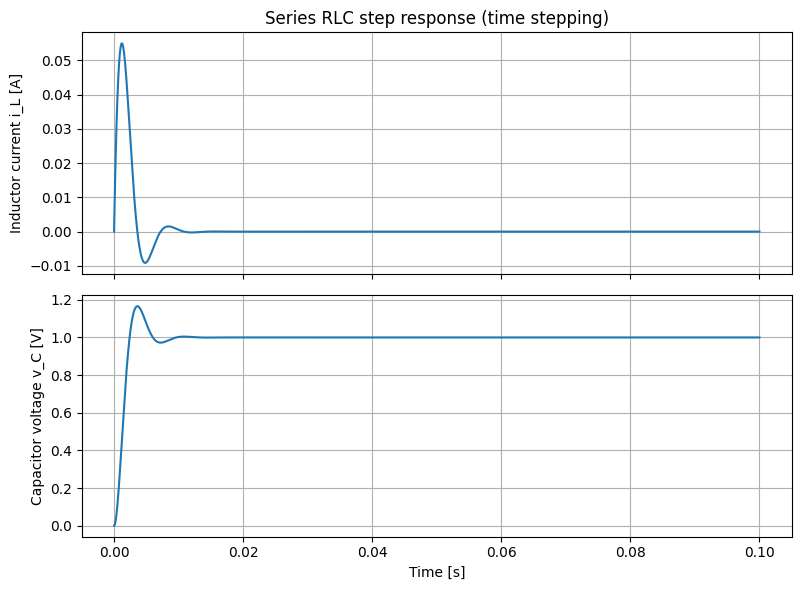

In [6]:
# ============================================
# Series RLC step response via time stepping
# x = [i_L, v_C]^T
# di_L/dt = (1/L) * (v_s - R*i_L - v_C)
# dv_C/dt = (1/C) * i_L
# ============================================

# Circuit parameters
R = 10.0        # [ohm]
L = 10e-3       # [H]
C = 100e-6      # [F]

# Simulation settings
t_end = 0.1     # [s] total simulation time
dt = 1e-5       # [s] time step
t = np.arange(0.0, t_end + dt, dt)
N = len(t)

# Input: 1 V step
Vs = np.ones(N)   # v_s(t) = 1 V for all t >= 0

# State-space matrices (real matrix differential equation)
# x_dot = A x + B u
A = np.array([
    [-R/L, -1.0/L],
    [ 1.0/C,    0.0]
])
B = np.array([
    [1.0/L],
    [0.0]
])

# Allocate state array: x = [i_L, v_C]^T
x = np.zeros((2, N))    # initial condition: i_L(0)=0, v_C(0)=0

# Time stepping (explicit Euler)
for k in range(N - 1):
    x_k = x[:, k]
    u_k = Vs[k]
    x_dot = A @ x_k + B.flatten() * u_k
    x[:, k + 1] = x_k + dt * x_dot

# Extract currents/voltages
i_L = x[0, :]
v_C = x[1, :]

# ============================================
# Plotting
# ============================================
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axes[0].plot(t, i_L)
axes[0].set_ylabel("Inductor current i_L [A]")
axes[0].set_title("Series RLC step response (time stepping)")
axes[0].grid(True)

axes[1].plot(t, v_C)
axes[1].set_ylabel("Capacitor voltage v_C [V]")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

plt.tight_layout()
plt.show()

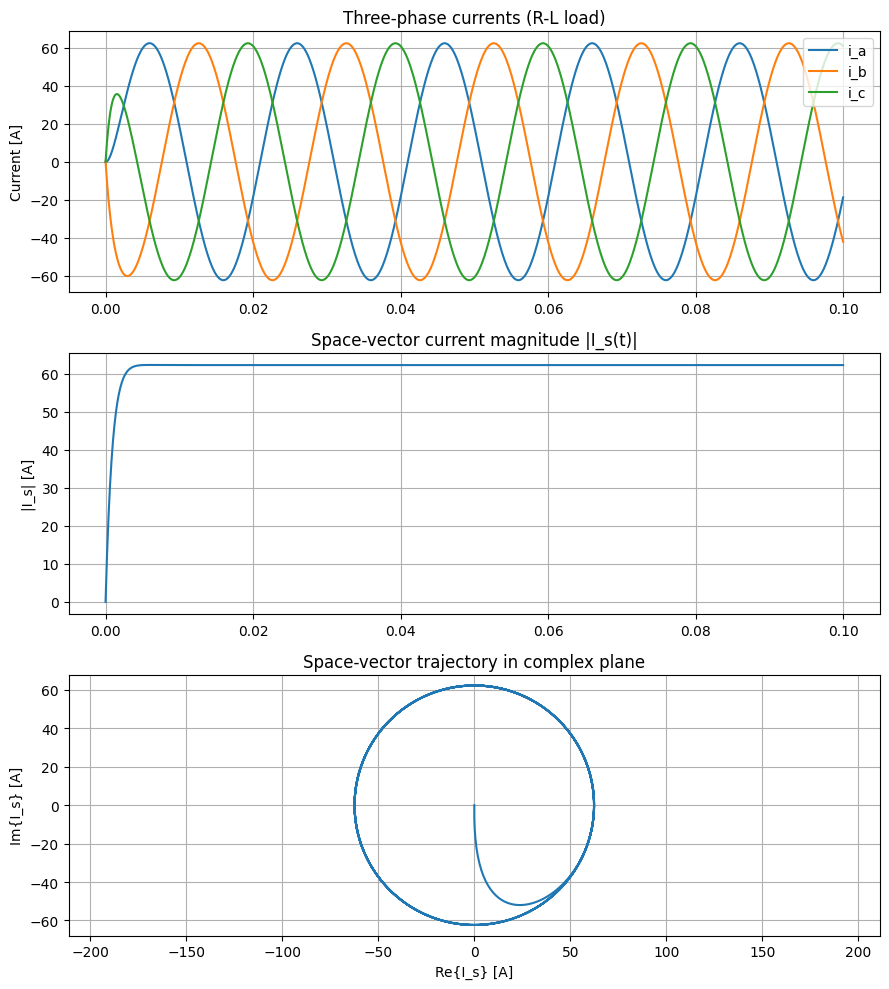

In [7]:
# ============================================
# 3-phase RL load driven by a balanced 3-phase source
# Time stepping (explicit Euler) + complex space-vector
# ============================================

# Circuit parameters
R = 5.0          # [ohm] phase resistance
L = 5e-3         # [H]   phase inductance

# Source parameters
f = 50.0                         # [Hz] fundamental frequency
omega = 2 * np.pi * f            # [rad/s]
V_phase_rms = 230.0              # [V] phase-to-neutral RMS
V_m = np.sqrt(2) * V_phase_rms   # [V] phase-to-neutral peak

# Simulation settings
t_end = 0.1          # [s] total simulation time
dt = 1e-4            # [s] time step
t = np.arange(0.0, t_end + dt, dt)
N = len(t)

# 3-phase source voltages (phase-to-neutral)
va = V_m * np.sin(omega * t)
vb = V_m * np.sin(omega * t - 2*np.pi/3)
vc = V_m * np.sin(omega * t - 4*np.pi/3)

# Stack into a 3xN array for convenience
vs = np.vstack((va, vb, vc))

# State: phase currents i_a, i_b, i_c
i = np.zeros((3, N))   # initial currents are zero

# State-space matrices (real 3x3 system):
# di/dt = A * i + B * v_s
A = -(R / L) * np.eye(3)
B = (1.0 / L) * np.eye(3)

# Time stepping (explicit Euler)
for k in range(N - 1):
    i_k = i[:, k]
    v_k = vs[:, k]
    di_dt = A @ i_k + B @ v_k
    i[:, k+1] = i_k + dt * di_dt

ia, ib, ic = i  # unpack rows

# ============================================
# Clarke transform (abc -> alpha-beta) and complex space vector
# ============================================

def abc_to_alpha_beta(ia, ib, ic):
    """
    Clarke transform for balanced 3-phase system.
    Returns i_alpha, i_beta.
    """
    # 2/3 scaling for power-invariant transform
    i_alpha = (2/3) * (ia - 0.5*ib - 0.5*ic)
    i_beta  = (2/3) * (np.sqrt(3)/2) * (ib - ic)
    return i_alpha, i_beta

i_alpha, i_beta = abc_to_alpha_beta(ia, ib, ic)
I_space = i_alpha + 1j * i_beta        # complex space vector
I_mag = np.abs(I_space)                # magnitude

# ============================================
# Plot results
# ============================================

fig, axes = plt.subplots(3, 1, figsize=(9, 10))

# 1) Phase currents
axes[0].plot(t, ia, label="i_a")
axes[0].plot(t, ib, label="i_b")
axes[0].plot(t, ic, label="i_c")
axes[0].set_title("Three-phase currents (R-L load)")
axes[0].set_ylabel("Current [A]")
axes[0].grid(True)
axes[0].legend(loc="upper right")

# 2) Space-vector magnitude
axes[1].plot(t, I_mag)
axes[1].set_title("Space-vector current magnitude |I_s(t)|")
axes[1].set_ylabel("|I_s| [A]")
axes[1].grid(True)

# 3) Space-vector trajectory in the complex plane
axes[2].plot(I_space.real, I_space.imag)
axes[2].set_title("Space-vector trajectory in complex plane")
axes[2].set_xlabel("Re{I_s} [A]")
axes[2].set_ylabel("Im{I_s} [A]")
axes[2].axis("equal")
axes[2].grid(True)

plt.tight_layout()
plt.show()

/var/folders/25/vg8ydb454_z3v37m53jqj5280000gn/T/ipykernel_48276/860996556.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  X[n] = (1.0 / T0) * np.trapz(integrand, tau)


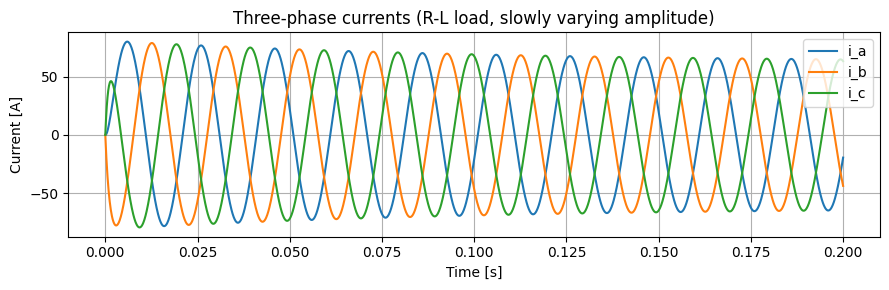

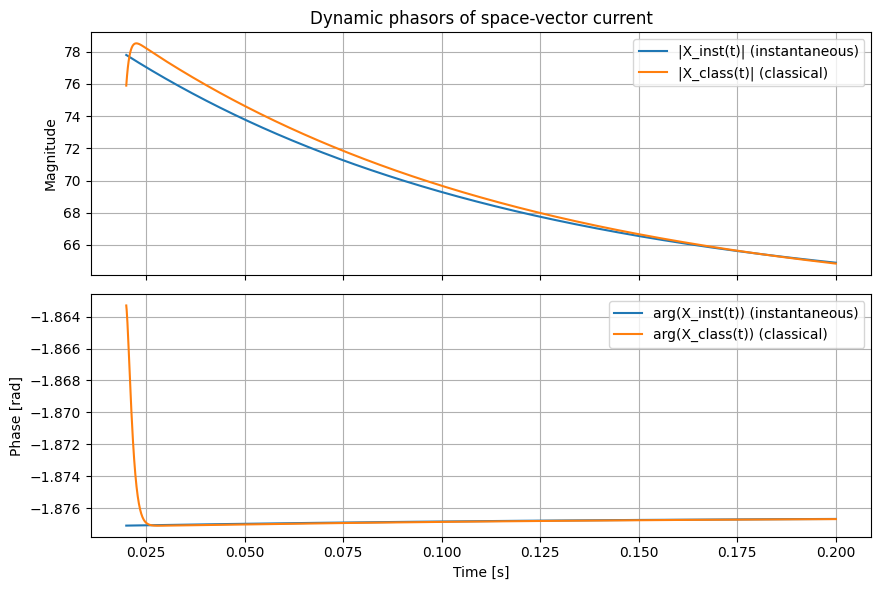

In [8]:
# ============================================
# 3-phase RL load + Dynamic Phasor demonstration
# ============================================

# -------- Circuit parameters --------
R = 5.0          # [ohm] phase resistance
L = 5e-3         # [H]   phase inductance

# -------- Source parameters --------
f0 = 50.0                      # [Hz] fundamental frequency
omega0 = 2 * np.pi * f0        # [rad/s]
T0 = 1.0 / f0                  # [s] fundamental period

V_phase_rms0 = 230.0           # [V] nominal phase-to-neutral RMS
V_m0 = np.sqrt(2) * V_phase_rms0  # peak voltage

# Slowly varying amplitude envelope for the source
t_end = 0.2        # [s] total simulation time
dt = 1e-4          # [s] time step
t = np.arange(0.0, t_end + dt, dt)
N = len(t)

tau_env = 0.1                     # [s] envelope time constant
A_env = 1.0 + 0.3 * np.exp(-t / tau_env)  # decays from 1.3 -> 1.0
V_m = V_m0 * A_env                # time-varying peak voltage

# -------- 3-phase source voltages (phase-to-neutral) --------
va = V_m * np.sin(omega0 * t)
vb = V_m * np.sin(omega0 * t - 2*np.pi/3)
vc = V_m * np.sin(omega0 * t - 4*np.pi/3)

vs = np.vstack((va, vb, vc))      # shape (3, N)

# -------- State-space model for 3-phase RL load --------
# di/dt = A * i + B * v_s
A_mat = -(R / L) * np.eye(3)
B_mat = (1.0 / L) * np.eye(3)

# State: phase currents [i_a, i_b, i_c]^T
i = np.zeros((3, N))              # initial currents = 0

# Time stepping (explicit Euler)
for k in range(N - 1):
    i_k = i[:, k]
    v_k = vs[:, k]
    di_dt = A_mat @ i_k + B_mat @ v_k
    i[:, k+1] = i_k + dt * di_dt

ia, ib, ic = i  # unpack

# ============================================
# Clarke transform and space-vector current
# ============================================

def abc_to_alpha_beta(ia, ib, ic):
    """
    Power-invariant Clarke transform (abc -> alpha-beta).
    Returns i_alpha, i_beta.
    """
    i_alpha = (2/3) * (ia - 0.5*ib - 0.5*ic)
    i_beta  = (2/3) * (np.sqrt(3)/2) * (ib - ic)
    return i_alpha, i_beta

i_alpha, i_beta = abc_to_alpha_beta(ia, ib, ic)
I_space = i_alpha + 1j * i_beta   # complex space-vector current

# ============================================
# Dynamic phasors of the space-vector current
# ============================================

def classical_dynamic_phasor(z, t, omega0, T0):
    """
    Classical (period-averaged) dynamic phasor for k = 1:

        X_class(t) = (1/T0) ∫_{t-T0}^{t} z(τ) e^{-jω0 τ} dτ

    The integral is evaluated numerically over a sliding window
    using the trapezoidal rule.
    """
    dt = t[1] - t[0]
    Nwin = int(round(T0 / dt))    # samples per period
    N = len(t)
    X = np.full(N, np.nan, dtype=complex)

    for n in range(Nwin - 1, N):
        tau = t[n - Nwin + 1 : n + 1]
        zw = z[n - Nwin + 1 : n + 1]
        integrand = zw * np.exp(-1j * omega0 * tau)
        X[n] = (1.0 / T0) * np.trapz(integrand, tau)

    return X

# Instantaneous dynamic phasor (no time averaging)
X_inst = I_space * np.exp(-1j * omega0 * t)

# Classical (period-averaged) dynamic phasor
X_class = classical_dynamic_phasor(I_space, t, omega0, T0)

# ============================================
# Plot results
# ============================================

fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3))
ax1.plot(t, ia, label="i_a")
ax1.plot(t, ib, label="i_b")
ax1.plot(t, ic, label="i_c")
ax1.set_title("Three-phase currents (R-L load, slowly varying amplitude)")
ax1.set_ylabel("Current [A]")
ax1.set_xlabel("Time [s]")
ax1.grid(True)
ax1.legend(loc="upper right")
fig1.tight_layout()

# ---- Dynamic phasor magnitudes and phases ----
fig2, (ax2a, ax2b) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# Ignore the first period where X_class is NaN
mask = t >= T0

ax2a.plot(t[mask], np.abs(X_inst[mask]), label="|X_inst(t)| (instantaneous)")
ax2a.plot(t[mask], np.abs(X_class[mask]), label="|X_class(t)| (classical)")
ax2a.set_ylabel("Magnitude")
ax2a.set_title("Dynamic phasors of space-vector current")
ax2a.grid(True)
ax2a.legend()

ax2b.plot(t[mask], np.unwrap(np.angle(X_inst[mask])),
          label="arg(X_inst(t)) (instantaneous)")
ax2b.plot(t[mask], np.unwrap(np.angle(X_class[mask])),
          label="arg(X_class(t)) (classical)")
ax2b.set_ylabel("Phase [rad]")
ax2b.set_xlabel("Time [s]")
ax2b.grid(True)
ax2b.legend()

fig2.tight_layout()

plt.show()
